# RatS Day2NSD recording info
- No timestamps were deleted after concatenating .dat files from various folders of open-ephys

In [7]:
import numpy as np
import subjects

sess = subjects.nsd.ratSday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.xml 
# channels: 195
sampling rate: 30000
lfp Srate (downsampled): 1250


In [13]:
sess.recinfo.channel_groups

array([array([19,  3, 26, 20,  5,  8, 14,  0,  4, 25]),
       array([ 2, 17, 16,  6, 24, 21, 10, 30, 22,  9,  1]),
       array([27, 18, 31, 12, 23, 28, 15, 11, 29,  7, 13]),
       array([36, 48, 58, 56, 45, 32, 53, 47, 33, 40, 50]),
       array([34, 41, 52, 54, 43, 37, 57, 60, 49, 44, 63]),
       array([46, 61, 59, 39, 35, 62, 42, 38, 55]),
       array([77, 66, 78, 65, 79, 64, 76, 67, 75, 68, 74, 69, 73, 70, 72, 71]),
       array([93, 82, 94, 81, 95, 80, 92, 83, 91, 84, 90, 85, 89, 86, 88, 87]),
       array([109,  98, 110,  97, 111,  96, 108,  99, 107, 100, 106, 101, 105,
              102, 104, 103])                                                 ,
       array([125, 114, 126, 113, 127, 112, 124, 115, 123, 116, 122, 117, 121,
              118, 120, 119])                                                 ,
       array([141, 130, 142, 129, 143, 128, 140, 131, 139, 132, 138, 133, 137,
              134, 136, 135])                                                 ,
       array([1

# Set probe configuration
- RatS_Day2NSD has two probes: 64chan-6shanks cambridge neurotech and 128chan-8shanks diagnostic biochips.
- Channel 51 on 64chan probe is skull eeg channel located above prefrontal cortex. This channel was a little buggy, the signal quality kept varying.
- The cambridge neurotech probe also has accelerometer data in channels: 192, 193, 194

<AxesSubplot:title={'center':'Probe 191ch'}>

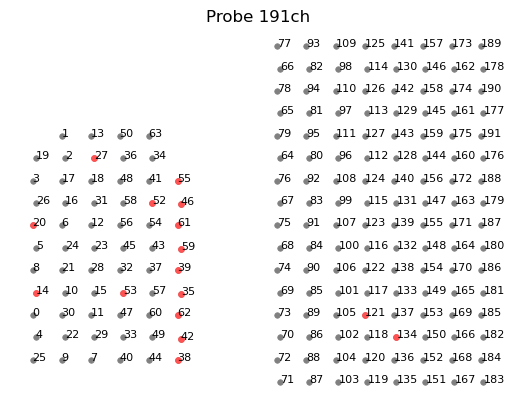

In [11]:
%matplotlib inline
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(6):
    chans = channel_groups[i]

    if len(chans)==10:
        n_cont = 5
        y_shift = [0,7.5]
    if len(chans)==11:
        n_cont = [6,5]
        y_shift = [0,7.5]
    if len(chans)==9:
        n_cont = [5,4]
        y_shift = [0,7,5]

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=n_cont,
        xpitch=16.5,
        ypitch=15,
        y_shift_per_column=y_shift,
        channel_id=np.append(
            channel_groups[i][1::2][::-1], channel_groups[i][::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

shanks = []
for i in range(6,14):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
# prbgrp.save()
plot_probe(prbgrp)

## Create epochs for your experimental paradigm
- RatS_Day2NSD had digitized noise in first ~2 hours of pre sleep. I somehow didn't notice that while recording, so the pre sleep is a lot shorter comapred to other animals.

In [12]:
sess.paradigm.to_dataframe()

,start,stop,label,duration
0,0,2358,pre,2358
1,2360,6031,maze1,3671
2,6033,36899,post,30866
3,36902,40233,maze2,3331


In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 2360,6033,36902],
        "stop": [2358, 6031, 36899, 40233],
        "label": ["pre", "maze1", "post",'maze2'],
    }
)

a = Epoch(epochs=epochs)
a.filename = sess.filePrefix.with_suffix(".paradigm.npy")
# a.save()


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Importing spiketrains from Phy

In [2]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatS/Day2NSD/spykcirc/RatS-Day2NSD-2020-11-27_10-22-29-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.peak_waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int)
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()


data saved


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [18]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


data saved


In [20]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


data saved


# Assign position data
- concatenated .dat file did not have any deleted timepoints

In [38]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder)

/data/Clustering/sessions/RatS/Day2NSD/position/Take 2020-11-27 11.07.50 AM.csv


In [39]:
import pandas as pd
from datetime import datetime

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(sync_time,unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# # ------- deleting intervals that were deleted from .dat file after concatenating
# ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
# for i in range(ndeletedintervals):
#     tnoisy_begin = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedStart (minutes)"][i], unit="m"
#     )
#     tnoisy_end = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedEnd (minutes)"][i], unit="m"
#     )

#     del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[
#         0
#     ]

#     data_time = np.delete(data_time, del_index)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)

In [40]:
position.filename = sess.filePrefix.with_suffix('.position.npy')
position.save()

data saved


In [42]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(sess.position.time,sess.position.y)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Checking position alignment with .dat file
- Comparing theta power, speed and position to check if high theta periods are correlated with the speed of the animal

In [43]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([158])
spec = signal_process.spectrogramBands(signal.traces[0])

In [48]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/1800)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.x)*100)
# plt.xlim([1500,1600])
plt.ylim([-400,400])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-400.0, 400.0)